# Cylindrical radiation
* Notes follow.
* This work was supported by the National Science Foundation under grant number CBET-1403403.

In [5]:
from IPython.display import HTML
HTML('<iframe src=https://ignite.byu.edu/nsf/FVDOM_cylindrical.pdf width=800 height=600></iframe>')

In [1]:
import numpy as np
import scipy.constants   as const
import matplotlib.pyplot as plt
from   scipy.integrate import quad
import sympy as sp
%matplotlib inline

## Setup

In [2]:
R  = 1
Tw = 300
σ  = const.Stefan_Boltzmann
I0 = σ*Tw**4/np.pi

kConst  = 1
TgConst = 1500
IbConst = σ*TgConst**4/np.pi

## FVDOM
* **Solve both halves of a circle.**
* For use with ODT, which is peicewise symmetric
* $-R <= r <= R$

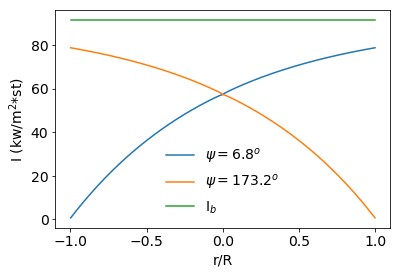

In [3]:
nr = 401   #1001
nθ = 40    #100
nψ = 80    #200

######################################

rf = np.linspace(-R,R,nr+1)
r  = 0.5*(rf[1:]+rf[:-1])
κ  = np.ones(nr) * kConst
θ  = np.linspace(0,np.pi/2,nθ)[::-1]
ψ  = np.linspace(0,np.pi,nψ)
V  = np.ones(nr)
for k in range(nr):
    if rf[k+1]*rf[k] > 0:
        V[k] = 0.5*np.abs(rf[k+1]**2 - rf[k]**2)
    else:
        V[k] = 0.5*np.abs(rf[k+1]**2 + rf[k]**2)
Asn = np.ones(nr)
for k in range(nr):
    Asn[k] = (rf[k+1] - rf[k])


dθ = θ[1]-θ[0]
dψ = ψ[1]-ψ[0]
dr = r[1]-r[0]

T  = np.ones(nr)*TgConst
Ib = σ*T**4/np.pi
Iinf = σ*Tw**4/np.pi

I  = np.zeros((nr,nθ,nψ))
α  = np.zeros((nθ,nψ))
β  = np.zeros((nθ,nψ))
q  = np.zeros(nr)
Q  = np.zeros(nr)

for i in range(nθ):
    for j in range(nψ):
        α[i,j] = np.sin(θ[i]) * np.cos(ψ[j])
        β[i,j] = np.sin(θ[i]) * np.sin(ψ[j])

        
######################################

for i in range(nθ):
    
    #AAAAAAAAAAAAAAAAAA RHS, march <---- from BC, ψ goes clockwise from ----> dir
    
    j = nψ-1
    
    k = nr-1
    I[k,i,j] = (V[k]*κ[k]*Ib[k] - α[i,j]*np.abs(rf[k+1])*Iinf) / \
               (-α[i,j]*np.abs(rf[k]) - α[i,j]*Asn[k] + V[k]*κ[k])
        
    for k in range(nr-2, int(nr/2), -1):
        I[k,i,j] = (V[k]*κ[k]*Ib[k] - α[i,j]*np.abs(rf[k+1])*I[k+1,i,j]) / \
                   (-α[i,j]*np.abs(rf[k]) - α[i,j]*Asn[k] + V[k]*κ[k])
            
    # Other j 
            
    for j in range(nψ-2, int(nψ/2)-1, -1):
        
        k = nr-1
        I[k,i,j] = (V[k]*κ[k]*Ib[k] - α[i,j]*np.abs(rf[k+1])*Iinf             + β[i,j]*Asn[k]/dψ*I[k,i,j+1]) / \
                   (-α[i,j]*np.abs(rf[k]) - α[i,j]*Asn[k] + V[k]*κ[k]         + β[i,j]*Asn[k]/dψ)
         
        for k in range(nr-2, int(nr/2), -1):
            I[k,i,j] = (V[k]*κ[k]*Ib[k] - α[i,j]*np.abs(rf[k+1])*I[k+1,i,j]   + β[i,j]*Asn[k]*I[k,i,j+1]/dψ) / \
                       (-α[i,j]*np.abs(rf[k]) - α[i,j]*Asn[k] + V[k]*κ[k]     + β[i,j]*Asn[k]/dψ)
                
    #BBBBBBBBBBBBBBBBBBB LHS, march ----> from BC, ψ goes counterclockwise from ----> dir
    
    j = 0
    
    k = 0
    I[k,i,j] = (V[k]*κ[k]*Ib[k] + α[i,j]*np.abs(rf[k])*Iinf) / \
               ( α[i,j]*np.abs(rf[k+1]) + α[i,j]*Asn[k] + V[k]*κ[k])
        
    for k in range(1, int(nr/2)):
        I[k,i,j] = (V[k]*κ[k]*Ib[k] + α[i,j]*np.abs(rf[k])*I[k-1,i,j]) / \
                   ( α[i,j]*np.abs(rf[k+1]) + α[i,j]*Asn[k] + V[k]*κ[k])
            
    # Other j 
            
    for j in range(1, int(nψ/2)):
        
        k = 0
        I[k,i,j] = (V[k]*κ[k]*Ib[k] + α[i,j]*np.abs(rf[k])*Iinf             + β[i,j]*Asn[k]/dψ*I[k,i,j-1]) / \
                   ( α[i,j]*np.abs(rf[k+1]) + α[i,j]*Asn[k] + V[k]*κ[k]     + β[i,j]*Asn[k]/dψ)
         
        for k in range(1, int(nr/2)):
            I[k,i,j] = (V[k]*κ[k]*Ib[k] + α[i,j]*np.abs(rf[k])*I[k-1,i,j]       + β[i,j]*Asn[k]/dψ*I[k,i,j-1]) / \
                       ( α[i,j]*np.abs(rf[k+1]) + α[i,j]*Asn[k] + V[k]*κ[k]     + β[i,j]*Asn[k]/dψ)
                
    #                                                                         ^
    #                                                                        /                                                                           
    #CCCCCCCCCCCCCCCCCC RHS, march ----> from center, ψ goes clockwise from / dir
    
    for j in range(int(nψ/2)-1,-1,-1):
        
        k = int(nr/2)
        I[k,i,j] = I[k-1,i,j] #+ (r[k]-r[k-1])*(I[k-1,i,j]-I[k-2,i,j])/(r[k-1]-r[k-2]) # extrapolation
        
        for k in range(int(nr/2)+1, nr):
            I[k,i,j] = (V[k]*κ[k]*Ib[k] + α[i,j]*np.abs(rf[k])*I[k-1,i,j]       + β[i,j]*Asn[k]/dψ*I[k,i,j+1]) / \
                       ( α[i,j]*np.abs(rf[k+1]) - α[i,j]*Asn[k] + V[k]*κ[k]     + β[i,j]*Asn[k]/dψ)
                
    #                                                                             ^
    #                                                                              \                                                                           
    #DDDDDDDDDDDDDDDDDD LHS, march <---- from center, ψ goes counterclockwise from \ dir
                
    for j in range(int(nψ/2), nψ):
        
        k = int(nr/2)
        I[k,i,j] = I[k+1,i,j] #+ (r[k]-r[k+1])*(I[k+1,i,j]-I[k+2,i,j])/(r[k+1]-r[k+2]) # extrapolation
        
        for k in range(int(nr/2)-1, -1, -1):
            I[k,i,j] = (V[k]*κ[k]*Ib[k] - α[i,j]*np.abs(rf[k+1])*I[k+1,i,j]   + β[i,j]*Asn[k]/dψ*I[k,i,j-1]) / \
                       (-α[i,j]*np.abs(rf[k]) + α[i,j]*Asn[k] + V[k]*κ[k]     + β[i,j]*Asn[k]/dψ)
    
######################################

q = np.zeros(nr)
for k in range(nr):
    for i in range(nθ):
        for j in range(nψ):
            q[k] -= 4*dθ*dψ*I[k,i,j]*α[i,j]*np.sin(θ[i])

Q = np.zeros(nr)
Q[0]    = -(q[1] -q[0])  /(r[1] -r[0])
Q[1:-1] = -(q[2:]-q[:-2])/(r[2:]-r[:-2])
Q[-1]   = -(q[-1]-q[-2]) /(r[-1]-r[-2])

######################################

j1 = 3
j2 = -4 
plt.rc("font", size=14)
plt.plot(r/R,I[:,0,j1] /1000,'-')
plt.plot(r/R,I[:,0,j2]/1000,'-')
plt.plot(r/R,np.ones(len(r))*Ib[0]/1000);
plt.xlabel('r/R')
plt.ylabel(r'I (kw/m$^2$*st)')
plt.legend([r'$\psi=$'+'{:3.1f}'.format(ψ[j1]*180/np.pi)+r'$^o$', \
            r'$\psi=$'+'{:3.1f}'.format(ψ[j2]*180/np.pi)+r'$^o$', \
            r'I$_b$'], frameon=False)

plt.figure()
plt.plot(r/R,q/1000)
plt.xlabel('r/R')
plt.ylabel(r'q (kW/m$^2$)')

plt.figure()
plt.plot(r/R,Q/1000)
plt.xlabel('r/R')
plt.ylabel(r'Q (kW/m$^3$)');

Qdom2 = Q.copy()
rdom2 = r.copy()

## FVDOM
* **Solve symmetric problem**
* $0 <= r <= R$

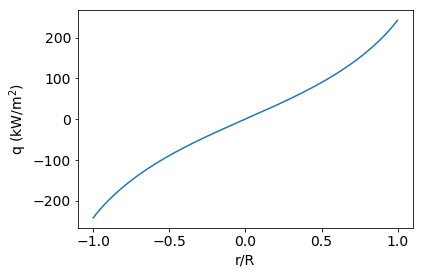

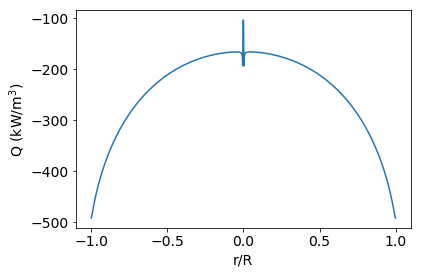

In [4]:
nr = 401
nθ = 40
nψ = 80

######################################

rf = np.linspace(0,R,nr+1)
r  = 0.5*(rf[1:]+rf[:-1])
κ  = np.ones(nr) * kConst
θ  = np.linspace(0,np.pi/2,nθ)[::-1]
ψ  = np.linspace(0,np.pi,nψ)
V  = np.ones(nr)
for k in range(nr):
    if rf[k+1]*rf[k] > 0:
        V[k] = 0.5*np.abs(rf[k+1]**2 - rf[k]**2)
    else:
        V[k] = 0.5*np.abs(rf[k+1]**2 + rf[k]**2)
Asn = np.ones(nr)
for k in range(nr):
    Asn[k] = (rf[k+1] - rf[k])

dθ = θ[1]-θ[0]
dψ = ψ[1]-ψ[0]
dr = r[1]-r[0]

T  = np.ones(nr)*TgConst
Ib = σ*T**4/np.pi
Iinf = σ*Tw**4/np.pi

I  = np.zeros((nr,nθ,nψ))
α  = np.zeros((nθ,nψ))
β  = np.zeros((nθ,nψ))
q  = np.zeros(nr)
Q  = np.zeros(nr)

for i in range(nθ):
    for j in range(nψ):
        α[i,j] = np.sin(θ[i]) * np.cos(ψ[j])
        β[i,j] = np.sin(θ[i]) * np.sin(ψ[j])
        
######################################

for i in range(nθ):
    
    #---------------------
    
    j = nψ-1
    
    k = nr-1
    I[k,i,j] = (V[k]*κ[k]*Ib[k] - α[i,j]*rf[k+1]*Iinf) / \
               (-α[i,j]*rf[k] - α[i,j]*Asn[k] + V[k]*κ[k])
    
    for k in range(nr-2,-1,-1):
        I[k,i,j] = (V[k]*κ[k]*Ib[k] - α[i,j]*rf[k+1]*I[k+1,i,j]) / \
                   (-α[i,j]*rf[k] - α[i,j]*Asn[k] + V[k]*κ[k])
            
    #---------------------
    
    for j in range(nψ-2,int(nψ/2)-1,-1):
        
        k = nr-1
        I[k,i,j] = (V[k]*κ[k]*Ib[k] - α[i,j]*rf[k+1]*Iinf + β[i,j]*Asn[k]/dψ*I[k,i,j+1]) / \
                   (-α[i,j]*rf[k] - α[i,j]*Asn[k] + V[k]*κ[k] + β[i,j]*Asn[k]/dψ)
            
        for k in range(nr-2,-1,-1):
            I[k,i,j] = (V[k]*κ[k]*Ib[k] - α[i,j]*rf[k+1]*I[k+1,i,j] + β[i,j]*Asn[k]/dψ*I[k,i,j+1]) / \
                       (-α[i,j]*rf[k] - α[i,j]*Asn[k] + V[k]*κ[k] + β[i,j]*Asn[k]/dψ)
                
    #---------------------
                
    for j in range(int(nψ/2)-1,-1,-1):
        
        k = 0
        
        I[k,i,j] = I[0,i,nψ-1-j]
            
        for k in range(1,nr):
            I[k,i,j] = (V[k]*κ[k]*Ib[k] + α[i,j]*rf[k]*I[k-1,i,j] + β[i,j]*Asn[k]*I[k,i,j+1]/dψ) / \
                       ( α[i,j]*rf[k+1] - α[i,j]*Asn[k] + V[k]*κ[k] + β[i,j]*Asn[k]/dψ)
            
    #break

######################################

q = np.zeros(nr)
for k in range(nr):
    for i in range(nθ):
        for j in range(nψ):
            q[k] -= 4*dθ*dψ*I[k,i,j]*α[i,j]*np.sin(θ[i])
            
r = np.hstack((-r[::-1],r))
q = np.hstack((-q[::-1], q))

Q = np.zeros(len(r))
Q[0]    = -(q[1] -q[0])  /(r[1] -r[0])
Q[1:-1] = -(q[2:]-q[:-2])/(r[2:]-r[:-2])
Q[-1]   = -(q[-1]-q[-2]) /(r[-1]-r[-2])


######################################

j1 = 3
j2 = -4 
II = np.hstack(( I[::-1,0,j1], I[:,0,j2] ))
plt.rc("font", size=14)
plt.plot(r/R,II/1000,'-')
plt.plot(r/R,II[::-1]/1000,'-')
plt.plot(r/R,np.ones(len(r))*Ib[0]/1000);
plt.xlabel('r/R')
plt.ylabel(r'I (kw/m$^2$*st)')
plt.legend([r'$\psi=$'+'{:3.1f}'.format(ψ[j1]*180/np.pi)+r'$^o$', \
            r'$\psi=$'+'{:3.1f}'.format(ψ[j2]*180/np.pi)+r'$^o$', \
            r'I$_b$'], frameon=False)

plt.figure()
plt.plot(r/R,q/1000)
plt.xlabel('r/R')
plt.ylabel(r'q (kW/m$^2$)')

plt.figure()
plt.plot(r/R,Q/1000)
plt.xlabel('r/R')
plt.ylabel(r'Q (kW/m$^3$)');

rdom1 = r.copy()
Qdom1 = Q.copy()


## Ray tracing numerical integration
* Exact solution, but implemented numerically.
* I is computed using implicit Euler method.

In [5]:
def getκ(r):
    return kConst
    #return 1 + 0.2*np.cos(8*r)
def Tg(r):
    return TgConst
    #return 1200 + 900* np.cos(8*r)
def getIb(r):
    return σ*Tg(r)**4/np.pi

def I_IE(R,r,θ,ψ):
    
    ns = 200
    s = ( r*np.cos(np.pi-ψ) + np.sqrt(R**2 - r**2 + r**2*np.cos(np.pi-ψ)**2) ) 
    ns = int(ns*s/2/R) + 1
    s /= np.abs(np.sin(θ))
    ds = s/ns
    
    I  = I0
    sp = 0
    for i in range(ns):
        sp += ds
        #rl = np.sqrt( r**2 + (s-sp)**2*np.cos(ψ)**2 - 2*r*(s-sp)*np.cos(ψ)*np.cos(np.pi-θ) )
        rl = np.sqrt( r**2 + (s-sp)**2*np.sin(θ)**2 - 2*r*(s-sp)*np.sin(θ)*np.cos(np.pi-ψ) )
        κrl = getκ(rl)
        I = (I + ds*κrl*getIb(rl))/(1+κrl*ds)
    
    return I

In [6]:
nr = 200
nθ = 5
nψ = 10

dθ = np.pi/2/nθ
dψ = np.pi/nψ
θ  = np.linspace(dθ/2, np.pi/2-dθ/2, nθ)
ψ  = np.linspace(dψ/2, np.pi-dψ/2, nψ)
rq = np.linspace(0,R,nr+1)
r  = 0.5*(rq[1:]+rq[:-1])
 
q  = np.zeros(nr+1)

for ir in range(nr+1):
    for iθ in range(nθ):
        for iψ in range(nψ):
            s = ( rq[ir]*np.cos(np.pi-ψ[iψ]) + np.sqrt(R**2 - rq[ir]**2 + rq[ir]**2*np.cos(np.pi-ψ[iψ])**2) ) /np.abs(np.sin(θ[iθ]))
            II = I_IE(R,rq[ir],θ[iθ],ψ[iψ])
            q[ir] -= 4*II*np.cos(ψ[iψ])*np.sin(θ[iθ])**2*dθ*dψ  # 4* since ψ goes from 0:π/2 instead of 0:2π 

Q = -(q[1:] - q[:-1])/(rq[1]-rq[0])

QrayN = np.hstack((Q[::-1], Q))
rrayN = np.hstack((-r[::-1], r))


## Ray tracing, analytic solution

* Assumes constant $I_b$ and constant $k$

In [7]:
nr = 200
nθ = 5 
nψ = 10

dθ = np.pi/2/nθ
dψ = np.pi/nψ
θ  = np.linspace(dθ/2, np.pi/2-dθ/2, nθ)
ψ  = np.linspace(dψ/2, np.pi-dψ/2, nψ)
rq = np.linspace(0,R,nr+1)
r  = 0.5*(rq[1:]+rq[:-1])
 
q  = np.zeros(nr+1)

for ir in range(nr+1):
    for iθ in range(nθ):
        for iψ in range(nψ):
            s = ( rq[ir]*np.cos(np.pi-ψ[iψ]) + np.sqrt(R**2 - rq[ir]**2 + rq[ir]**2*np.cos(np.pi-ψ[iψ])**2) ) /np.abs(np.sin(θ[iθ]))
            I = IbConst - (IbConst-I0)*np.exp(-kConst*s) 
            q[ir] -= 4*I*np.cos(ψ[iψ])*np.sin(θ[iθ])**2*dθ*dψ  # 4* since ψ goes from 0:π/2 instead of 0:2π 

Q = -(q[1:] - q[:-1])/(rq[1]-rq[0])

QrayA = np.hstack((Q[::-1], Q))
rrayA = np.hstack((-r[::-1],r))


## Exact solution

* Assumes constant $I_b$ and constant $k$
* Integrate with quad

In [8]:
def get_Q(r):
    
    def fI_1(θ,ψ):
        s = ( r*np.cos(np.pi-ψ) + \
              np.sqrt(R**2 - r**2 + r**2*np.cos(np.pi-ψ)**2) ) / \
            np.abs(np.sin(θ))
        dsdr = ( np.cos(np.pi-ψ) + (r*np.cos(np.pi-ψ)**2-r)/
               np.sqrt(R**2-r**2+r**2*np.cos(np.pi-ψ)**2) )/ \
               np.abs(np.sin(θ))
        return np.cos(ψ)*np.sin(θ)**2*kConst*(IbConst-I0)*np.exp(-kConst*s)*dsdr
               
    def fI_2(ψ):
        return quad(fI_1, 1E-6, np.pi/2, args=(ψ,))[0]
    return 4*quad(fI_2, 0, np.pi)[0] #  4* for symmetry in θ and ψ

#---------------------------------

r = np.linspace(0,R,100)
Q    = np.zeros(len(r))
for i in range(len(r)):
    Q[i] = get_Q(r[i])

rexct = np.hstack((-r[::-1], r))
Qexct = np.hstack((Q[::-1], Q))

## Plot

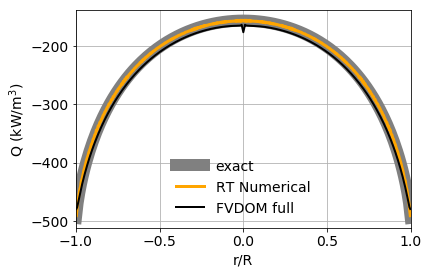

In [9]:
plt.rc('font', size=14)
plt.plot(rexct/R, Qexct/1000, color='gray',  linewidth=12, label='exact') 
#plt.plot(rrayA/R, QrayA/1000, color='red', linewidth=4, label='RT Analytic') 
plt.plot(rrayN/R, QrayN/1000, color='orange',  linewidth=3, label='RT Numerical') 
plt.plot(rdom2/R, Qdom2/1000, color='black',  linewidth=2, label='FVDOM full')
#plt.plot(rdom1/R, Qdom1/1000, color='blue', linewidth=2, label='FVDOM symm')
plt.xlabel("r/R")
plt.ylabel(r"Q (kW/m$^3$)")
plt.xlim([-1,1])
plt.legend(frameon=False)
plt.grid();